# Data prep

In [1]:
# !pip install mp_api
# !pip install schnetpack
# !pip install mp_api.client
# !pip uninstall numpy --y
# !pip install numpy

In [2]:
# from mp_api.client import MPRester
# from emmet.core.summary import HasProps
# import pandas as pd
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error
# import matplotlib.pyplot as plt

# # add your api key here
# api_key = 'Jy8KgNH5XRyGoHYK6ANxnBmgqFVvtOaN'

In [3]:
# from mp_api.client import MPRester

# with MPRester(api_key) as mpr:
#     docs = mpr.summary.search(
#         has_props = [HasProps.piezoelectric], fields=["material_id", "e_ij_max"]
#     )
#     mpids = [(doc.material_id, doc.e_ij_max) for doc in docs]
#     material_data = []
#     for doc in docs:
#         material_id = doc.material_id
#         e_ij_max = doc.e_ij_max
#         band_gap = doc.band_gap

#         structure_doc = mpr.materials.get_data_by_id(material_id, fields=["structure", "band_gap"])
#         lattice = structure_doc.structure.lattice
#         a, b, c = lattice.abc
#         alpha, beta, gamma = lattice.angles
#         space_group = structure_doc.structure.get_space_group_info()
#         atomic_positions = [site.coords for site in structure_doc.structure.sites]
#         atomic_elements = [site.specie.symbol for site in structure_doc.structure.sites]

#         material_data.append({
#             "material_id": material_id,
#             "e_ij_max": e_ij_max,
#             "band_gap": band_gap,
#             "lattice_a": a,
#             "lattice_b": b,
#             "lattice_c": c,
#             "angle_alpha": alpha,
#             "angle_beta": beta,
#             "angle_gamma": gamma,
#             "space_group": space_group[1],
#             "atomic_positions": atomic_positions,
#             "atomic_elements": atomic_elements
#         })

# df = pd.DataFrame(material_data)

# Splitting Data

In [ ]:
# !pip install schnetpack
# !pip install mendeleev
# !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install git+https://github.com/pyg-team/pytorch_geometric.git
# !pip install torch_geometric

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import schnetpack as spk
from schnetpack.representation import SchNet
import matplotlib.pyplot as plt
from schnetpack.nn.cutoff import CosineCutoff
from sklearn.preprocessing import LabelEncoder
import ast
from torch_geometric.data import Data
import numpy as np
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.data import DataLoader
import torch_geometric

In [2]:
data = pd.read_csv('piezoelectric_materials_data.csv')
X = data.drop('e_ij_max', axis=1)
y = data['e_ij_max']

def safe_eval(str_repr):
    try:
        return ast.literal_eval(str_repr)
    except ValueError:
        safe_str = str_repr.replace('array', '')
        return ast.literal_eval(safe_str)

data['atomic_positions'] = data['atomic_positions'].apply(safe_eval)
data['atomic_elements'] = data['atomic_elements'].apply(safe_eval)
element_encoder = LabelEncoder()
all_elements = sum(data['atomic_elements'].tolist(), [])
element_encoder.fit(all_elements)
def elements_to_numbers(elements):
    return element_encoder.transform(elements).tolist()

data['atomic_numbers'] = data['atomic_elements'].apply(elements_to_numbers)
piezoelectricity_values = data['e_ij_max'].values

In [3]:
def create_graph_data(row, piezoelectricity_value):
    positions = torch.tensor(row['atomic_positions'], dtype=torch.float)
    atomic_numbers = torch.tensor(row['atomic_numbers'], dtype=torch.long).view(-1, 1)
    node_features = torch.cat((atomic_numbers, positions), dim=1)
    num_atoms = positions.size(0)
    edge_index = torch.combinations(torch.arange(num_atoms), with_replacement=False)
    return Data(x=node_features, edge_index=edge_index.t().contiguous(), y=torch.tensor([piezoelectricity_value], dtype=torch.float))

graph_data_list = [create_graph_data(row, piezoelectricity_values[i]) for i, row in data.iterrows()]


In [4]:
class GCNPiezoelectricModel(torch.nn.Module):
    def __init__(self, node_features, hidden_dim):
        super(GCNPiezoelectricModel, self).__init__()
        self.conv1 = GCNConv(node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = x.float().view(-1, node_features)
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = torch_geometric.nn.global_mean_pool(x, data.batch)
        x = self.fc(x)
        return x

node_features = 1
model = GCNPiezoelectricModel(node_features, hidden_dim=64)


In [5]:
from sklearn.model_selection import train_test_split
from torch_geometric.data import DataLoader

train_data, test_data = train_test_split(graph_data_list, test_size=0.1, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)


/Users/sonnyyoung/miniconda3/lib/python3.8/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [6]:
node_features = graph_data_list[0].num_node_features
model = GCNPiezoelectricModel(node_features, hidden_dim=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
train_losses = []

for epoch in range(100):
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output.view(-1), data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}: Loss = {avg_loss}")

model.eval()
test_losses = []
total_samples = 0

with torch.no_grad():
    for data in test_loader:
        output = model(data)
        loss = F.mse_loss(output.view(-1), data.y, reduction='sum')
        test_losses.append(loss.item())
        total_samples += data.y.size(0) 

avg_test_loss = sum(test_losses) / total_samples 
print(f"Average Test MSE per Sample: {avg_test_loss}")

Epoch 1: Loss = 13.468563612430327
Epoch 2: Loss = 13.84477097308764
Epoch 3: Loss = 13.459442195071968
Epoch 4: Loss = 13.659910053976121
Epoch 5: Loss = 13.522552725127948
Epoch 6: Loss = 13.254942470981229
Epoch 7: Loss = 13.223291342937818
Epoch 8: Loss = 13.371802648869894
Epoch 9: Loss = 13.162070598333113
Epoch 10: Loss = 13.346398658649896
Epoch 11: Loss = 13.481181671222052
Epoch 12: Loss = 13.29827191368226
Epoch 13: Loss = 13.174952847662793
Epoch 14: Loss = 13.277951350135188
Epoch 15: Loss = 13.375533948662461
Epoch 16: Loss = 13.307405523074571
Epoch 17: Loss = 13.318681961746625
Epoch 18: Loss = 13.407769176588264
Epoch 19: Loss = 13.298068673700415
Epoch 20: Loss = 13.143688262149851
Epoch 21: Loss = 13.057582406587498
Epoch 22: Loss = 13.11709885539547
Epoch 23: Loss = 13.234426028946395
Epoch 24: Loss = 13.435445650290417
Epoch 25: Loss = 13.19233987055799
Epoch 26: Loss = 13.139694636226983
Epoch 27: Loss = 13.19445381305551
Epoch 28: Loss = 16.770448433455602
Epoch 

/var/folders/pg/22_lhlhj5tzb89wyhd4r3j880000gn/T/ipykernel_2934/1069787038.py:14: RuntimeWarning: invalid value encountered in log
  y =  np.log(np.array(predictions) + 0.00001)


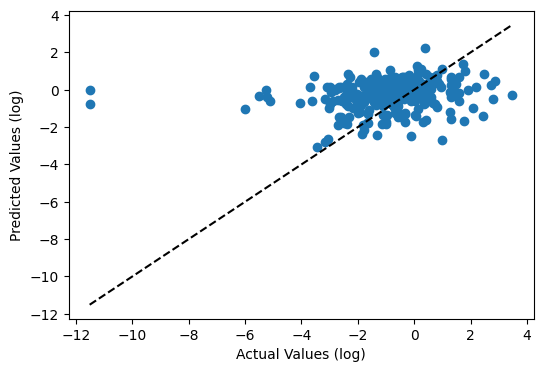

In [43]:
actuals = []
predictions = []

model.eval()

with torch.no_grad():
    for data in test_loader:
        output = model(data)
        actuals.extend(data.y.view(-1).tolist()) 
        predictions.extend(output.view(-1).tolist())

plt.figure(figsize=(6,4))
x = np.log(np.array(actuals) + 0.00001)
y =  np.log(np.array(predictions) + 0.00001)
plt.scatter(x, y)
plt.xlabel('Actual Values (log)')
plt.ylabel('Predicted Values (log)')
range = [min(min(x), min(y)), max(max(x), max(y))]
plt.plot(range, range, 'k--')
plt.show()